In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize as op
from scipy.interpolate import UnivariateSpline
import copy 

## Data L(k)

In [4]:
err_L = 1 * 2**0.5 # mm
err_f = 1            # Hz

print(err_L, err_f)

1.4142135623730951 1


In [5]:
data_air    = pd.read_excel("213.ods", engine='odf', usecols = "A, D:E, I:J, N:O, S:T, X:Y", sheet_name = 0)
data_carbon = pd.read_excel("213.ods", engine='odf', usecols = "A, D:E, I:J, N:O", sheet_name = 1)

f_air = np.array([
    3500,
    3750,
    4000,
    4250,
    4500
])

f_carbon = np.array([
    3248,
    4000,
    5007,
])

err_T = 0.1

In [6]:
def rename_cols(data, f):
    tuples = [
        ("f", "k"),
        # (str(f[i]), "l")
        # (str(f[i]), "L") ...
    ]
    for i in range(0, len(f)):
        tuples.append((str(f[i]), "l"))
        tuples.append((str(f[i]), "L"))

    data.columns = pd.MultiIndex.from_tuples(tuples)
    return data

In [7]:
data_air = rename_cols(data_air, f_air)
data_carbon = rename_cols(data_carbon, f_carbon)
data_carbon

f   3248          4000        5007     
   k      l      L      l      L    l    L
0  0   39.0    0.0   37.0    0.0   13    0
1  1   90.0   51.0   78.0   41.0   41   28
2  2  143.0  104.0  109.0   72.0   71   58
3  3  197.0  158.0  147.0  110.0   99   86
4  4    NaN    NaN  188.0  151.0  128  115
5  5    NaN    NaN  226.0  189.0  156  143
6  6    NaN    NaN    NaN    NaN  184  171
7  7    NaN    NaN    NaN    NaN  213  200

In [8]:
def latex_fmt(i, f, names):
    tmp = {
        (str(f[i]), names['l']) : "{:.0f}",
        (str(f[i]), names['L']) : "{:.0f}",
    }
    return tmp

In [9]:
def print_data(data, f, filename):
    names = {'k' : r"$k$",
             'f' : r"$f$, Гц",
             'l' : r"$l$, мм",
             'L' : r"$L$, мм"
            }

    out_fmt = {(names['f'], names['k']) : "{:.0f}"}

    for i in range(0, len(f)):
        o_list = latex_fmt(i, f, names)
        out_fmt.update(o_list)

    latex = data.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt, na_rep = "")

    latex.to_latex(
                buf = filename,
                column_format="c" * data.shape[1],
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    return latex

In [10]:
print_data(data_carbon, f_carbon, "L_k_carbon.tex")
print_data(data_air, f_air, "L_k_air.tex")


# Process L(k)

In [11]:
colour = ["red", "blue", "green", "yellow", "purple", "orange"]

def lin_plot_Lk(x, y, label = None, i = 1):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    x_space = np.linspace(0, max(x), 100)
    plt.plot(x_space, equ(x_space), label = label, c = colour[i])
    plt.errorbar(x, y, xerr=0, yerr=err_L, fmt='.', c = colour[i])
    

In [12]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [13]:
def plot_data(data, f, filename):
    a     = np.array([])      # a
    err_a = np.array([])      # errors a

    for i in range(0, len(f)):
        y = data[(str(f[i]), 'L')].dropna() # remove NaNs
        x = data[('f', 'k')][0:len(y)]      # slice x to have the same size as y
        
        df, dat = least_sq(x, y)
        latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
        print(latex)

        a     = np.append(a, dat[5])
        err_a = np.append(err_a, dat[6])

        label = r"$f = " + str(f[i]) + r"$ Гц"
        lin_plot_Lk(x, y, label, i)

    plt.title("$L \; (k)$")
    plt.ylabel(r"$L$, мм")
    plt.xlabel(r"$k$")
    plt.grid(True)
    plt.legend(fontsize = 8, framealpha = 0.1)

    print("Coeffs")
    print(a)
    print(err_a)
    plt.savefig(filename)
    
    return a, err_a

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
2.00e+00 & 2.00e+00 & 98.80 & 4.90e+03 & 9.90e+01 & 49.50 & 0.10 & -0.20 & 0.24 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
2.00e+00 & 2.00e+00 & 93.00 & 4.29e+03 & 9.26e+01 & 46.30 & 0.19 & 0.40 & 0.47 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
2.00e+00 & 2.00e+00 & 86.80 & 3.80e+03 & 8.72e+01 & 43.60 & 0.20 & -0.40 & 0.49 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
2.50e+00 & 2.92e+00 & 102.33 & 4.94e+03 & 1.20e+02 & 41.14 & 0.19 & -0.52 & 0.57 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & 

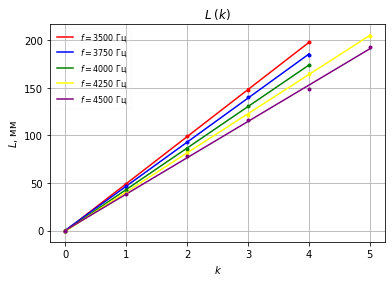

In [14]:
a_air, err_a_air = plot_data(data_air, f_air, "L_k_air.pdf")

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
1.50e+00 & 1.25e+00 & 78.25 & 3.47e+03 & 6.59e+01 & 52.70 & 0.48 & -0.80 & 0.90 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
2.50e+00 & 2.92e+00 & 93.83 & 4.11e+03 & 1.09e+02 & 37.51 & 0.66 & 0.05 & 2.01 \\
\end{tabular}

\begin{tabular}{rrrrrrrrr}
$\overline{x}$ & $\sigma_x^2$ & $\overline{y}$ & $\sigma_y^2$ & $r_{xy}$ & $a$ & $\Delta a$ & $b$ & $\Delta b$ \\
3.50e+00 & 5.25e+00 & 100.12 & 4.28e+03 & 1.50e+02 & 28.56 & 0.08 & 0.17 & 0.35 \\
\end{tabular}

Coeffs
[52.7        37.51428571 28.55952381]
[0.47958315 0.66229862 0.0827645 ]


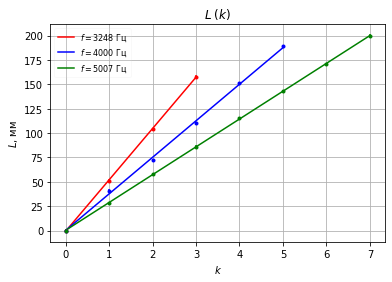

In [15]:
a_carbon, err_a_carbon = plot_data(data_carbon, f_carbon, "L_k_carbon.pdf")

In [16]:
def print_processed(mu, a, err_a, f, filename):
    lmd = 2 * a
    err_lmd = 2 * err_a

    c = lmd * f / 1000  # mm->m conversion
    print(c)
    err_c = c * ((err_lmd/lmd)**2 + (err_f/f)**2)**0.5
    
    T = 296

    processed = pd.DataFrame({'f'     : f,
                              'a'     : a,   'err_a'       : err_a,
                              'lmd'   : lmd, 'err_lmd'     : err_lmd,
                            })

    names = {
        'f'     : r"$f$, Гц",

        'a'     : r"$a$, мм",
        'err_a' : r"$\sigma_a$, мм",

        'lmd'       : r"$\lambda$, мм",
        'err_lmd'   : r"$\sigma_{\lambda}$, мм",

        'c'     : r"$c$, м/c",
        'err_c' : r"$\sigma_c$, м/с",    
    }

    out_fmt = {
        names['f']     : "{:.0f}",

        names['a']     : "{:.1f}",
        names['err_a'] : "{:.1f}",

        names['lmd']       : "{:.1f}",
        names['err_lmd']   : "{:.1f}",

        names['c']     : "{:.1f}",
        names['err_c'] : "{:.1f}",
    }

    latex = processed.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = filename,
                column_format="c" * len(names),
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    
    # Evaluating results
    c_av = np.mean(c)
    err_c_av = 0

    for i in range(len(f)):
        err_c_av += (c[i] - c_av)**2

    err_c_av **= 0.5

    print("c_av:", c_av)
    print(err_c_av)

    gamma_av = mu/(8.31 * T) * c_av**2
    err_gamma_av = gamma_av * ((2 * err_c_av/c_av)**2 + (err_T/T)**2)**0.5

    print("gamma:", gamma_av)
    print(err_gamma_av)


In [17]:
print_processed(0.029, a_air, err_a_air, f_air, "processed_L_k_air.tex")
print_processed(0.044, a_carbon, err_a_carbon, f_carbon, "processed_L_k_carbon.tex")

[346.5        347.25       348.8        349.71428571 343.54285714]
c_av: 347.16142857142864
4.768793113053076
gamma: 1.4209153198462043
0.03903984108711036
[342.3392     300.11428571 285.99507143]
c_av: 309.4828523809524
41.46064970931477
gamma: 1.713298850451026
0.4590531553310791


## Data F(k)

In [18]:
data = pd.read_excel("213.ods", engine='odf', usecols = "A, D:E, I:J, N:O, S:T, X:Y, AC:AD", sheet_name = 2)

T = np.array([
    296,
    303,
    308,
    313,
    318,
    323
])
err_T = 0.1

L = 740
err_L = 1

# f_carbon = np.array([])

data

,k,f,F,f.1,F.1,f.2,F.2,f.3,F.3,f.4,F.4,f.5,F.5
0,0,251,0,255,0,257,0,259,0,261,0,262,0
1,1,477,226,482,227,487,230,490,231,494,233,498,236
2,2,704,453,712,457,718,461,723,464,729,468,734,472
3,3,933,682,943,688,951,694,958,699,966,705,973,711
4,4,1162,911,1175,920,1185,928,1194,935,1204,943,1213,951
5,5,1393,1142,1409,1154,1420,1163,1431,1172,1443,1182,1454,1192
6,6,1624,1373,1642,1387,1655,1398,1668,1409,1681,1420,1694,1432
7,7,1856,1605,1877,1622,1891,1634,1906,1647,1922,1661,1936,1674
8,8,2087,1836,2110,1855,2127,1870,2144,1885,2161,1900,2178,1916
9,9,2318,2067,2344,2089,2363,2106,2382,2123,2401,2140,2419,2157


In [19]:
def rename_cols(data, T):
    tuples = [
        ("T", "k"),
        # (str(f[i]), "l")
        # (str(f[i]), "L") ...
    ]
    for i in range(0, len(T)):
        tuples.append((str(T[i]), "f"))
        tuples.append((str(T[i]), "F"))

    data.columns = pd.MultiIndex.from_tuples(tuples)
    return data

In [20]:
data = rename_cols(data, T)
data

T   296         303         308         313         318         323      
   k     f     F     f     F     f     F     f     F     f     F     f     F
0  0   251     0   255     0   257     0   259     0   261     0   262     0
1  1   477   226   482   227   487   230   490   231   494   233   498   236
2  2   704   453   712   457   718   461   723   464   729   468   734   472
3  3   933   682   943   688   951   694   958   699   966   705   973   711
4  4  1162   911  1175   920  1185   928  1194   935  1204   943  1213   951
5  5  1393  1142  1409  1154  1420  1163  1431  1172  1443  1182  1454  1192
6  6  1624  1373  1642  1387  1655  1398  1668  1409  1681  1420  1694  1432
7  7  1856  1605  1877  1622  1891  1634  1906  1647  1922  1661  1936  1674
8  8  2087  1836  2110  1855  2127  1870  2144  1885  2161  1900  2178  1916
9  9  2318  2067  2344  2089  2363  2106  2382  2123  2401  2140  2419  2157

In [21]:
def latex_fmt(i, T, names):
    tmp = {
        (str(T[i]), names['f']) : "{:.0f}",
        (str(T[i]), names['F']) : "{:.0f}",
    }
    return tmp

In [22]:
def print_data(data, T, filename):
    names = {'k' : r"$k$",
             'T' : r"$T, ^{\circ} C$",
             'f' : r"$f$, Гц",
             'F' : r"$F$, Гц"
            }

    out_fmt = {(names['T'], names['k']) : "{:.0f}"}

    for i in range(0, len(T)):
        o_list = latex_fmt(i, T, names)
        out_fmt.update(o_list)

    latex = data.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt, na_rep = "")

    latex.to_latex(
                buf = filename,
                column_format="c" * data.shape[1],
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    return latex

In [23]:
print_data(data, T, "F_k.tex")

# Process F(k)

In [24]:
colour = ["red", "blue", "green", "yellow", "purple", "orange"]

def lin_plot(x, y, xerr, yerr, label = None, i = 1):
    coeffs = np.polyfit(x, y, 1)
    equ = lambda x: coeffs[0] * x + coeffs[1]
    
    x_space = np.linspace(min(x), max(x), 100)
    plt.plot(x_space, equ(x_space), label = label, c = colour[i])
    plt.errorbar(x, y, xerr=xerr, yerr=yerr, fmt='.', c = colour[i])
    

In [25]:
mnk_fmt = {
        '$\overline{x}$' : "{:.2e}",
        '$\sigma_x^2$'   : "{:.2e}",
        '$\overline{y}$' : "{:.2f}",
        '$\sigma_y^2$'   : "{:.2e}",
        '$r_{xy}$'       : "{:.2e}",
        '$a$'            : "{:.2f}",
        '$\Delta a$'     : "{:.2f}",
        '$b$'            : "{:.2f}",
        '$\Delta b$'     : "{:.2f}",
}

def least_sq(x, y):
    sx = (x**2).mean() - (x.mean())**2
    sy = (y**2).mean() - (y.mean())**2
    rxy = (y*x).mean() - (y.mean() * x.mean())
    a = rxy / sx
    da = (1/(len(x) - 2) * (sy/sx - a**2))**(0.5)
    b = y.mean() - a * x.mean()
    db = da*(sx + (x.mean())**2)**(1/2)
    dat = pd.DataFrame({
        '$\overline{x}$' : [x.mean()],
        '$\sigma_x^2$'   : [sx],
        '$\overline{y}$' : [y.mean()],
        '$\sigma_y^2$'   : [sy],
        '$r_{xy}$'       : [rxy],
        '$a$'            : [a],
        '$\Delta a$'     : [da],
        '$b$'            : [b],
        '$\Delta b$'     : [db],
    })
    
    return dat, [x.mean(), sx, y.mean(), sy, rxy, a, da, b, db]

In [32]:
def plot_data(data, T, filename):
    a     = np.array([])      # a
    err_a = np.array([])      # errors a

    for i in range(0, len(T)):
        x = 1 / (data[('T', 'k')] + 1)
        y = data[(str(T[i]), 'f')]

        df, dat = least_sq(x, y)
        latex = df.style.hide(level=0, axis=0).format(mnk_fmt).to_latex()
        # print(latex)

        a     = np.append(a, dat[5])
        err_a = np.append(err_a, dat[6])

        label = r"$T = " + str(T[i]) + r"\; K$"
        lin_plot(x, y, 0, 1, label, i)

    plt.title("$F \; (k)$")
    plt.ylabel(r"$F$, Гц")
    plt.xlabel(r"$k$")
    plt.grid(True)
    plt.legend(fontsize = 8, framealpha = 0.1)

    print("Coeffs")
    print(a)
    print(err_a)
    plt.savefig(filename)
    
    return a, err_a

Coeffs
[-2024.72555373 -2046.24919576 -2062.18370187 -2078.82171793
 -2095.72333514 -2112.56255068]
[524.8880792  530.97305844 534.88331233 539.56434659 543.7198003
 547.82647588]


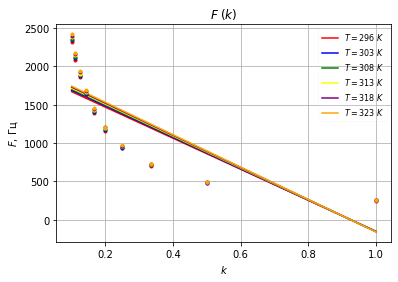

In [33]:
a, err_a = plot_data(data, T, "F_k.pdf")

In [80]:
def print_processed(c, c_err, a, a_err, T, filename):
    
    processed = pd.DataFrame({'T'    : T,
                              'a'    : a,     'err_a'     : err_a,
                              'c'    : c,     'err_c'     : err_c,
                              'gamma': gamma, 'err_gamma' : err_gamma
                            })

    names = {
        'T'     : r"$T, \;^{\circ} C$",

        'a'     : r"$a, \; \text{c}^{-1}$",
        'err_a' : r"$\sigma_a, \; \text{c}^{-1}$",

        'c'     : r"$c$, м/c",
        'err_c' : r"$\sigma_c$, м/с",
        
        'gamma' : r"$\gamma$",
        'err_gamma' : r"$\sigma_{\gamma}$"
    }

    out_fmt = {
        names['T']     : "{:.1f}",

        names['a']     : "{:.1f}",
        names['err_a'] : "{:.1f}",

        names['c']     : "{:.1f}",
        names['err_c'] : "{:.1f}",

        names['gamma']     : "{:.3f}",
        names['err_gamma'] : "{:.3f}",
    }

    latex = processed.rename(
                columns=(names)
            ).style.hide(level=0, axis=0).format(out_fmt).to_latex(
                buf = filename,
                column_format="c" * len(names),
                hrules=True,
                multicol_align = 'c',
                environment = ''
            )
    
    # Evaluating results
    gamma_av = np.mean(gamma)
    err_gamma_av = 0

    for i in range(len(T)):
        err_gamma_av += (gamma[i] - gamma_av)**2

    err_gamma_av **= 0.5

    print("gamma_av:", gamma_av)
    print(err_gamma_av)


In [81]:
c = 2 * a * L / 1000  # mm->m conversion
err_c = c * ((err_a/a)**2 + (err_L/L)**2)**0.5

mu = 0.02898
gamma = mu / (8.31 * T) * c**2
err_gamma = gamma * ((2 * err_c/c)**2 + (err_T/T)**2)**0.5

print_processed(c, err_c, a, err_a, T, "processed_F_k.tex")

gamma_av: 1.3617534858666673
0.0029317009301459375


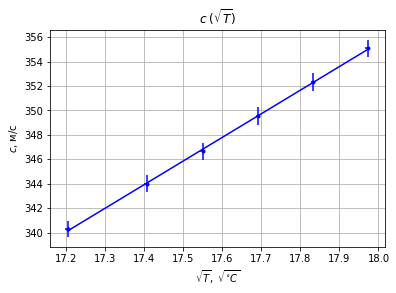

In [82]:
lin_plot(np.sqrt(T), c, err_T/np.sqrt(T), err_c)

plt.title("$c \; (\sqrt{T})$")
plt.ylabel(r"$c$, м/с")
plt.xlabel(r"$\sqrt{T}, \; \sqrt{^{\circ} C}$")
plt.grid(True)
plt.savefig("c_sqrt_T.pdf")
